# Churn Prediction

One of the challenges faced by companies that offers contract services, such as banks and telecom, is to prevent their customers from stopping using their service, which is called churn. In this scenario, being able to predict who is likely to cancel their contract can be a valuable tool, as the company can offer discounts and new service conditions in order to keep these users.   

Machine Learning can help solving this problem. Using past data from customers and with the information if they churned or not, it is possible to create a model that can predict if present customers are about to leave the service.   

The goal of this project is to create a churn prediction model for customers of a bank. The [dataset](https://www.kaggle.com/datasets/shubh0799/churn-modelling) used contains details of the bank's customers, such as Credit Score, Balance, Age and Location, and whether or not they've closed their account or continued to use the service. The project goes through a detailed analysis that tries to identify trends and other useful information from the data, followed by a study of the machine learning algorithms that can offer the best solutions for this problem.    

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

We begin by reading the raw data and count the number of features and samples.

In [2]:
data = pd.read_csv('data/Churn_Modelling.csv')

print("Samples:", data.shape[0])
print("Features:", data.shape[1])
data.head()

Samples: 10000
Features: 14


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Validation

Previous information about the columns of the dataset are the following:
- RowNumber and CustomerId: unique RowNumber and ID of each customer; these can be dropped safely.
- Surname: the customer's Surname.
- CreditScore: their credit score.
- Geography: which country they belong to.
- Gender: their gender.
- Age: age.
- Tenure: the time of bond with company.
- Balance: the amount left with them.
- NumOfProducts: the products they own.
- HasCrCard: if they have a credit card or not.
- IsActiveMember: how active member they are.
- EstimatedSalary: their estimated salary.
- Exited: Whether they stayed in the bank or left.

First, we should check if the types of the columns are consistent with their description.

In [3]:
data.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True) # Removing the RowNumber and CustomerId columns
data.dtypes

Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

- The Geography, Gender and Surname columns are the only non-numerical.
- The CreditScore contains a scoring that admits only integer values.
- The HasCrCard, IsActiveMember and Exited columns contain the integers 0 and 1 encoding False and True answers, so we can leave them as so.
- The two columns two float columns, Balance and EstimatedSalary, contains data related to currency.
- The Age and Tenure columns contain integer data, with information related to years;
- The NumOfProducts column is numeric, but it could also be classified as categorical. However, as there is clearly a ordering in the numbers, we can leave the encoding as that.

Thus, we don't need to make any fundamental change in the types of each column, as they seem to be consistent with their descriptions.

Now, let's check the Surname column: it can contain many unique values which won't help the model making good predictions.

In [4]:
data[['Surname']].nunique()

Surname    2932
dtype: int64

In fact, it contains a high number of unique values, and this high variance in the data may lead to overfitting. Also, when putting this model in production, it is very likely that new customers will come with new surnames that have not seen by the model during training, which can decrease its performance on unseen data. Thus, we are going drop the Surname column.

In [5]:
data.drop(['Surname'], axis=1, inplace=True)

Finally, we will check for missing values.

In [6]:
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There is no missing data. Let's also check for zero values in some of the numeric columns:

In [7]:
(data[['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'Balance', 'EstimatedSalary']] == 0).sum()

CreditScore           0
Age                   0
Tenure              413
NumOfProducts         0
Balance            3617
EstimatedSalary       0
dtype: int64

The Balance column contains zeros, but that is not a problem as a customer can have no money in their account. The same goes for the Tenure column, as a customer can be using the service for less than a year. 

Now that the dataset is cleaned and validated, we can begin to explore the data. 

## Exploratory Data Analysis

The first thing is to check the proportion between churn and non-churn customers:

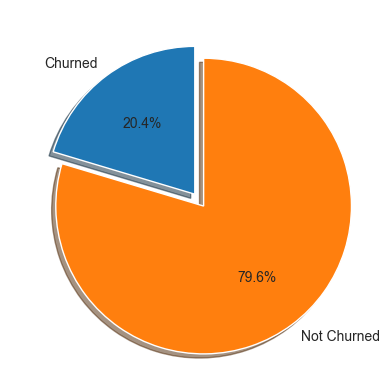

In [8]:
exited = data['Exited'].sum() / len(data)
not_exited = 1 - data['Exited'].sum() / len(data)

labels = 'Churned', 'Not Churned'
sizes = [exited, not_exited]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

We have an imbalanced dataset, as only 20.4% of the customers in this dataset have churned. This is what we are going to call the global mean of churning.  

Beforing exploring the data features, we are going to split the data into train and test sets, with a 80/20% ratio. This split must preserve the imbalance of the full dataset. Then, we follow to analyze the categorical and the numerical features individually.

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['Exited'], random_state=42)

### Categorical Data
To help the visualization of categorical data, we are going to write a function that creates barplots with the percentages of churn and not-churn for each category of a given feature.

In [10]:
def plotting_percentages(df, col, target, height=4, aspect=1.5, bbox_to_anchor=(0.85,0.8)):
    x, y = col, target
    
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()

    # Sort the column values for plotting    
    order_list = list(df[col].unique())
    order_list.sort()

    # Plot the figure
    g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=temp_df, 
                    height=height, aspect=aspect, order=order_list, legend_out=True)
    g.ax.set_ylim(0,100)
    g._legend.set_title("Churned")
    sns.move_legend(g, loc='center left', bbox_to_anchor=bbox_to_anchor, frameon=True)
    # replace labels
    new_labels = ['No', 'Yes']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)

    # Loop through each bar in the graph and add the percentage value    
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x, txt_y, txt)
        
    # Set labels and title
    plt.title(f'{col.title()} By Percent {target.title()}')
    plt.xlabel(f'{col.title()}')
    plt.ylabel(f'{target.title()} Percentage')

    return g

### Gender

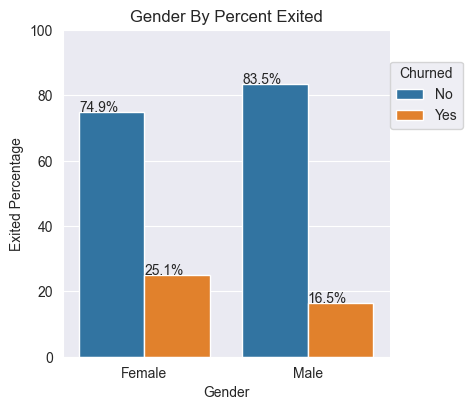

In [11]:
plotting_percentages(train_df, 'Gender', 'Exited', aspect=1)
plt.show()

From the graph, women tend to churn more than men. Also, the female churn mean is above the global mean, whereas the male churn mean is bellow it. With these differences between both, this feature will probably be important to the model. 

### Geography

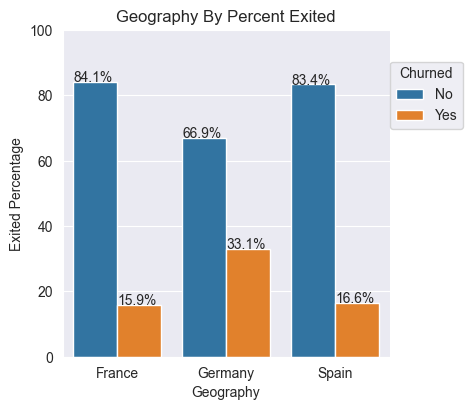

In [12]:
plotting_percentages(train_df, col='Geography', target='Exited', aspect=1)
plt.show()

Customers form Germany have a very high churn rate of 33.1%. The bank needs to pay special attention to these customers and try some strategy to avoid this. On the other hand, customers from France and Spain, have churn rates bellow the global mean.

## HasCrCard

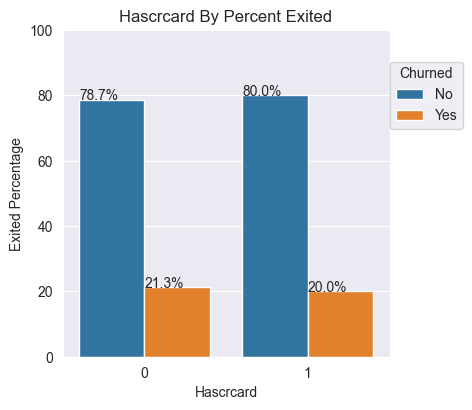

In [13]:
plotting_percentages(train_df, col='HasCrCard', target='Exited', aspect=1)
plt.show()

It seems that having a credit card or not does not affect the decision to churn, as both distributions are very similar. Customers who don't have a card have a slightly higher chance of churning, but both means are very close to the global mean. Thus, this is a feature that may not help the model and that perharps can be removed during training. 

### IsActiveMember

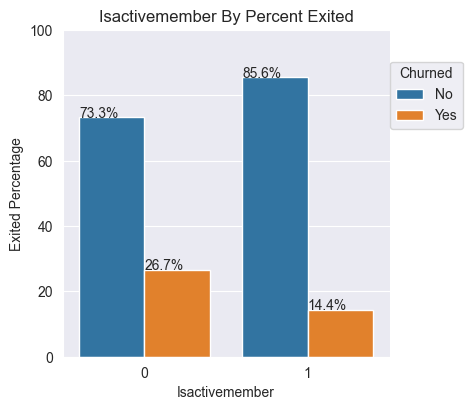

In [14]:
plotting_percentages(train_df, col='IsActiveMember', target='Exited', aspect=1)
plt.show()

Active members tend to churn less than non-active ones, which is agrees with the common sense (a customer who doesn't use a service tend to stop paying for it).

### NumofProducts

posx and posy should be finite values
posx and posy should be finite values


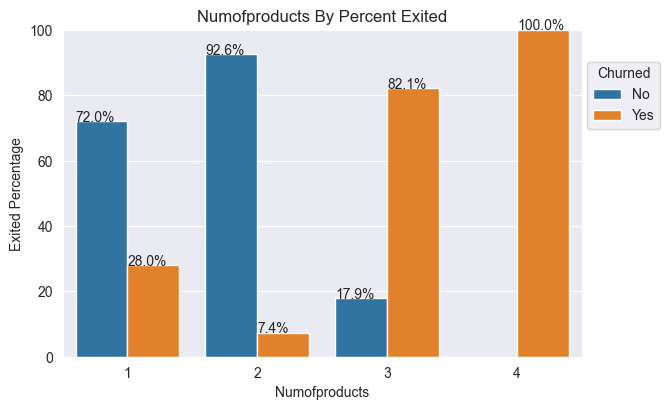

In [15]:
plotting_percentages(train_df, col='NumOfProducts', target='Exited', bbox_to_anchor=(0.9,0.8))
plt.show()

This distribution is very interesting and shows that the number of products has a close relantionship with the chance of customer churning. Customers with 3 or more products have high probability of closing their accounts, with 100% of those with 4 products doing that. These feature is decisive if the company wants to lower their churning rate, so special attention must given to this.   

Another interesting observation is that the trend is not linear: the churning rate of customers with 2 products is lesser than of those with 1. To understand why, it would be better to collect data about the type of product each customer has. 

### Tenure

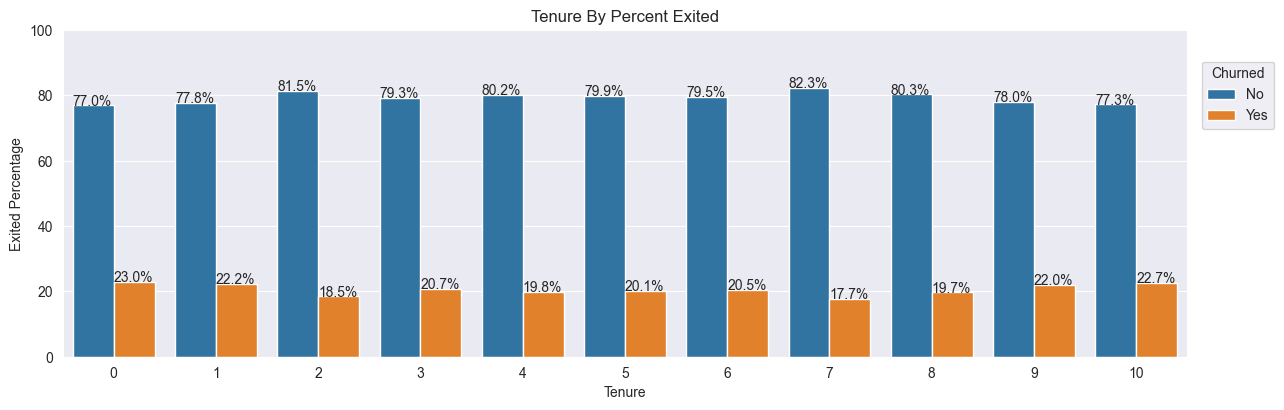

In [16]:
plotting_percentages(train_df, col='Tenure', target='Exited', aspect=3, bbox_to_anchor=(0.95,0.8))
plt.show()

The customers with less than 2 and more than 8 years of service are among those with the higher churning rates. Thus, new customers tend to churn more, as well as very old customers. 

### Numerical Data
Now, we analyze the numerical data. To help with the visualization, we are going to create a function to plot histograms for each feature. Also, we will create another fucntion to print the stastistcs of the data.  

In [17]:
def print_statistics(df, col):

    df_exit_0 = df.loc[df['Exited'] == 0, col]
    df_exit_1 = df.loc[df['Exited'] == 1, col]

    print("Mean not-churned: {} +/- {}".format(np.round(df_exit_0.mean(), 2), np.round(df_exit_0.std(), 2)))
    print("Mean churned: {} +/- {}".format(np.round(df_exit_1.mean(), 2), np.round(df_exit_1.std(), 2)))


def plot_histogram(df, col, xlabel, figsize=(6,3), print_stats=True):
    
    if print_stats == True:
        print_statistics(df, col)

    sns.set(style="darkgrid")

    df_exit_0 = df.loc[df['Exited'] == 0, :]
    df_exit_1 = df.loc[df['Exited'] == 1, :]

    plt.figure(figsize=figsize)
    sns.histplot(data=df_exit_0, x=col, color="blue", kde=True, label="Not-Churned")
    sns.histplot(data=df_exit_1, x=col, color="red" , kde=True, label="Churned")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel(xlabel)

    plt.show()

### Credit Score

Mean not-churned: 652.41 +/- 95.51
Mean churned: 644.26 +/- 100.48


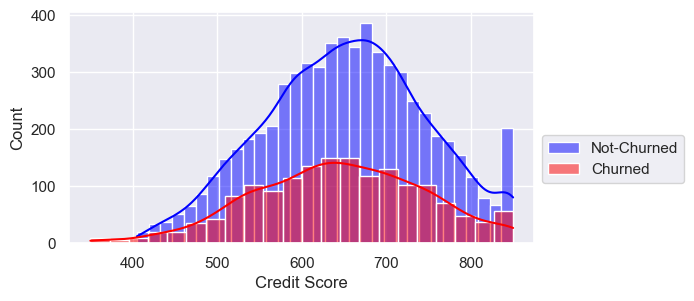

In [18]:
plot_histogram(df=train_df, col="CreditScore", xlabel="Credit Score")

Both distributions have very similar distributions, with their means and standard deviations being very similar. Thus, it is possible that this feature won't help the model making its predictions. 

### Age

Mean not-churned: 37.45 +/- 10.18
Mean churned: 44.78 +/- 9.82


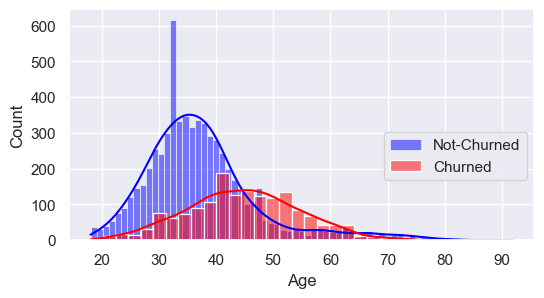

In [19]:
plot_histogram(df=train_df, col="Age", xlabel="Age")

Churning customers tend to be older than the non-churning ones. For ages above 45 years old, the count of churning customers is much higher than non-churning. Both distributions have very different means, thus this will be a important feature for the model to use.

### Balance

Mean not-churned: 72554.14 +/- 62833.34
Mean churned: 91337.28 +/- 57817.82


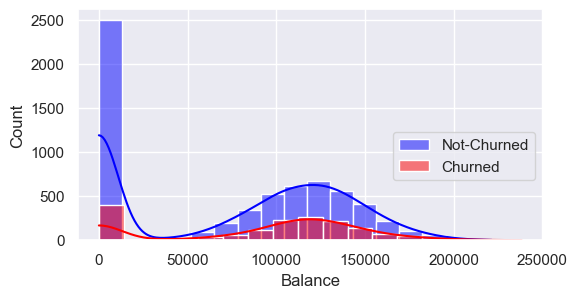

In [20]:
plot_histogram(df=train_df, col="Balance", xlabel="Balance")

The distributions have a difference between their means and standard deviations, with the mean balance of churning customers being lower than that of non-churning ones. Also, the Balance column contains a lot of zero values, that is, customers who doesn't have any money in their account. Let's look at the proportion of churning clients between those with no money: 

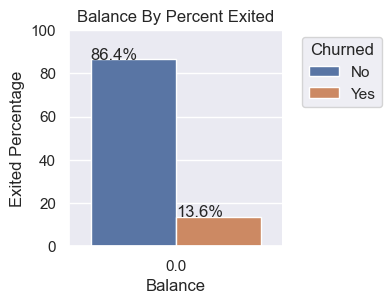

In [21]:
plotting_percentages(train_df[train_df["Balance"] == 0], 
                     col="Balance", 
                     target="Exited", 
                     height=3, 
                     aspect=1
                    )
plt.show()

Between customers with zero balance, 13.6% of them churned. This is almost 7% less than the global mean of 20%. Thus, customers with no money in their account tend to churn less.

### Estimated Salary

Mean not-churned: 99143.25 +/- 57166.52
Mean churned: 102026.98 +/- 57949.86


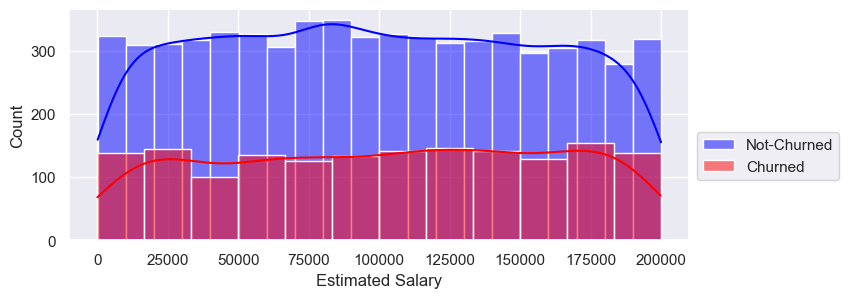

In [22]:
plot_histogram(df=train_df, col="EstimatedSalary", xlabel="Estimated Salary", figsize=(8,3))

The distriutions of Estimated Salary are almost the same for both categories of customers. Maybe this feature can be removed. 

## Model Fitting

### Approach
We are going to follow the next steps:

- Full dataset: First, we will the dataset containing all the available features to train 3 models: Logistic Regression (our baseline model), Random Forest and XGBoost. 
- Dropped features: Then, we are going to train these same 3 models, but this time we will remove features that, during EDA, seemed to show little difference between the distributions of churning and non-churning customers. These features are going to be EstimatedSalary, Balance and HasCrCard.

### Metric choice
As we are dealing with an imbalanced set, accuracy is not the best metric to be used: a no-skill model that predicts no-churn to all samples will have 80% of accuracy, the rate of negatives in the data. Therefore, we are going to use the area under the precision-recall curve (PR AUC).

We could also use the AUC of the ROC curve, but this metric can be too optimistic for imbalanced datasets, due to the use of true negatives in the false positive rate. The precision-recall curve deals with this problem by avoiding this rate and evaluating the fraction of true positives among positive predictions. Further discussion about this can be found in [this reference](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/).

The accuracy will also be measured, to check if the model has an accuracy that is at least as good as the no-skill model (greater than 80%).

### Data preprocessing
Before inputting the data into the model, it must be preprocessed. First, the categorical columns will be [one-hot encoded](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/), and then the data will be scaled, so each column has mean equal to 0 and standard deviation equal to 1.

### Auxiliary Functions
In order to keep the code clean, we are going to write a function to make the data pipeline, and some others to help us visualize the results.

In [23]:
# Removing target from train dataset
drop_cols = [
    'Exited'
]

X_train = train_df.drop(drop_cols, axis=1)
X_test = test_df.drop(drop_cols, axis=1)

# Creating target series
y_train = train_df['Exited']
y_test = test_df['Exited']

X_cat_cols = list(X_train.loc[:, X_train.dtypes == object].columns)
X_num_cols = list(X_train.loc[:, X_train.dtypes != object].columns)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             precision_recall_curve, 
                             roc_curve,
                             precision_score,
                             recall_score,
                             accuracy_score,
                             auc)

def make_pipeline(model, df):
    """Create a pipeline for a model."""

    cat_transf = OneHotEncoder(sparse_output=False,
                               handle_unknown="ignore")

    std_scaler = StandardScaler()

    # Determining categorical and numerical columns
    df_cat_cols = list(df.loc[:, df.dtypes == object].columns)
    df_num_cols = list(df.loc[:, df.dtypes != object].columns)

    transformer = ColumnTransformer(transformers=[("cat", cat_transf, df_cat_cols),
                                                  ("num_scaler", std_scaler, df_num_cols)],
                                    remainder='passthrough'
                                   )

    steps = [("transformer", transformer),
             ("model", model)]
    
    return Pipeline(steps)



def score_model(pipeline, X, y_true):
    """Score for a given pipeline using Accuracy, ROC AUC, Precision and Recall"""
    predict = pipeline.predict(X)
    predict_proba = pipeline.predict_proba(X)[:, 1]
    precisions, recalls, _ = precision_recall_curve(y_true, predict_proba)

    metrics = {"precision_recall_auc": auc(recalls, precisions),
               "accuracy": accuracy_score(y_true, predict),
              }
    
    return metrics


def print_feature_importances(model):
    """Print feature importances"""
    names = model.best_estimator_[:-1].get_feature_names_out()
    importances = model.best_estimator_['model'].feature_importances_

    for n, i in zip(names, importances):
        print(n, np.round(i, 3))


def plot_cm(y_true, pred_probs, t=0.5, title='Confusion matrix'):
    """Prints the confusion matrix for a given model and a threshold t."""

    predictions = pred_probs >= t

    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)

    print("Precision:", np.round(precision,4))
    print("Recall:", np.round(recall, 4))

    cm = confusion_matrix(y_true, predictions)

    plt.figure(figsize=(2.5,2.5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def print_scores(score_dict):
    """Print the scores"""

    for key, value in score_dict.items():
        print(key, np.round(value, 4))


def pr_curve_plot(y_true, y_proba, title=""):
    """Plot of the precision/recall curve"""

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3), gridspec_kw={'width_ratios': [1, 1.8]})
    ax1.plot(recalls, precisions, "g-")
    ax2.plot(thresholds, precisions[:-1], "tab:orange", label="Precision")
    ax2.plot(thresholds, recalls[:-1], "b--", label="Recall")
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Precision/Recall')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.suptitle(title)
    plt.show()
    

def save_scores(model_name, score_train, score_test, df):
    """Saves the results in a DataFrame"""
    
    results = pd.DataFrame({"Model": [model_name] * 2,
                            "Dataset": [
                                "Train", "Test"
                                ],
                            "PR AUC": [
                                score_train['precision_recall_auc'], 
                                score_test['precision_recall_auc']
                                ],
                            "Accuracy": [
                                score_train['accuracy'],
                                score_test['accuracy'],
                                ],
                        })

    final_scores = pd.concat([df, results])
    
    return final_scores

Finally, we will create and empty DataFrame to store the results:

In [25]:
final_scores = pd.DataFrame({"Model": [], 
                             "Dataset": [], 
                             "PR AUC": [],
                             "Accuracy": []})

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(random_state=10)

pipe_logreg = make_pipeline(logreg, X_train)

param_grid_lr = {
                 'model__C': [0.001, 0.01, 0.1, 0.5, 1, 10],
                 'model__solver': ['lbfgs', 'liblinear'],
                 'model__penalty': ['l2'],
                 'model__max_iter': [100, 200, 300, 400],
                }

gs_cv_lr = GridSearchCV(pipe_logreg, param_grid_lr,
                        scoring='average_precision', cv=5)

gs_cv_lr.fit(X_train, y_train)

score_train_lr = score_model(gs_cv_lr, X_train, y_train)
score_test_lr = score_model(gs_cv_lr, X_test, y_test)

proba_train_lr = gs_cv_lr.predict_proba(X_train)[:,1]
proba_test_lr = gs_cv_lr.predict_proba(X_test)[:,1]

final_scores = save_scores(model_name="Logistic Regression",
                           score_train=score_train_lr,
                           score_test=score_test_lr,
                           df=final_scores
                           )

# Print best estimator parameters
gs_cv_lr.best_params_

{'model__C': 10,
 'model__max_iter': 100,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

Now, let's plot the metrics for the training and test datasets:

Train:
precision_recall_auc 0.4671
accuracy 0.8108


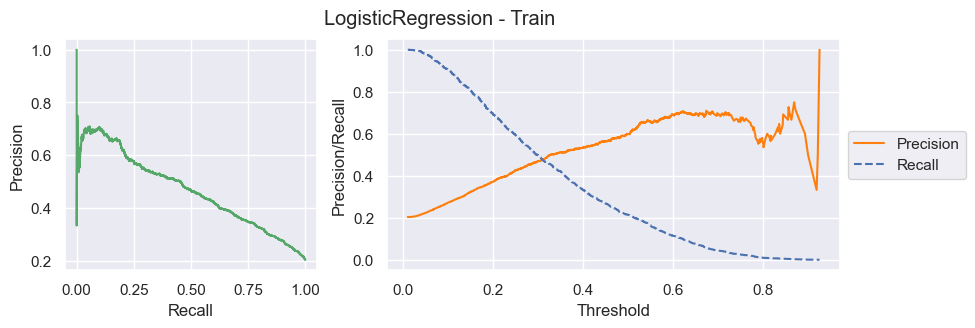

Test:
precision_recall_auc 0.4778
accuracy 0.808


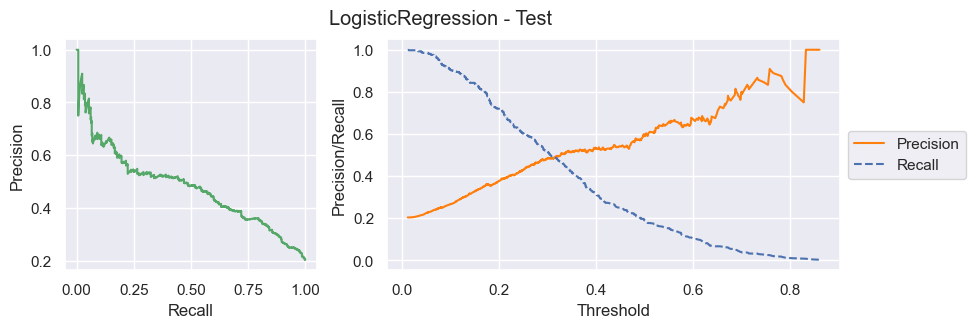

In [27]:
#Score
print('Train:')
print_scores(score_train_lr)
pr_curve_plot(y_train, proba_train_lr, "LogisticRegression - Train")
print('Test:')
print_scores(score_test_lr)
pr_curve_plot(y_test, proba_test_lr, "LogisticRegression - Test")

These are very poor scores, the Logistic Regression model has an accuracy very similar to the no-skill model, and the precision-recall curve is worst than that. The model is no overfitting, though. 

Train
Precision: 0.4689
Recall: 0.4988


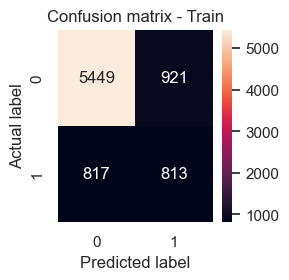

In [28]:
print("Train")
plot_cm(y_train, proba_train_lr, t=0.3, title='Confusion matrix - Train')

Test
Precision: 0.4862
Recall: 0.5184


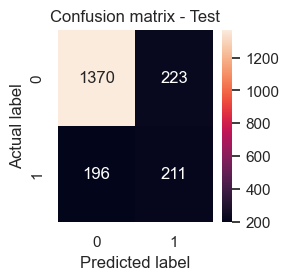

In [29]:
print("Test")
plot_cm(y_test, proba_test_lr, t=0.3, title='Confusion matrix - Test')

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# rfc = RandomForestClassifier(class_weight="balanced", random_state=15)
rfc = RandomForestClassifier(random_state=15)


pipe_rfc_cv = make_pipeline(rfc, X_train)

param_grid_rfc = {
    'model__max_depth': [10, 20, 50, 100, 200, None],
    'model__n_estimators': [10, 20, 50, 100, 300, 500],
    'model__max_leaf_nodes': [4, 8, 16, 24, None],
    'model__min_samples_leaf': [1, 5, 10, 20],
}

rs_cv_rfc = RandomizedSearchCV(estimator = pipe_rfc_cv,
                               param_distributions = param_grid_rfc,
                               n_iter=40, cv=5,
                               verbose=0, scoring='average_precision',
                               random_state=81, n_jobs = 4)

rs_cv_rfc.fit(X_train, y_train)

proba_train_rfc = rs_cv_rfc.predict_proba(X_train)[:,1]
proba_test_rfc = rs_cv_rfc.predict_proba(X_test)[:,1]

score_train_rfc = score_model(rs_cv_rfc, X_train, y_train)
score_test_rfc = score_model(rs_cv_rfc, X_test, y_test)

# Saving scores
final_scores = save_scores(model_name="Random Forest",
                           score_train=score_train_rfc,
                           score_test=score_test_rfc,
                           df=final_scores
                           )

# Print feature importances
rs_cv_rfc.best_params_

{'model__n_estimators': 100,
 'model__min_samples_leaf': 5,
 'model__max_leaf_nodes': None,
 'model__max_depth': 100}

Train:
precision_recall_auc 0.9007
accuracy 0.9044


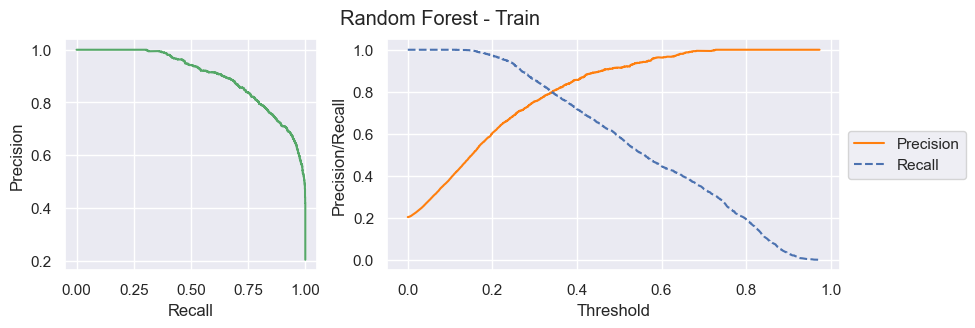

Test:
precision_recall_auc 0.6992
accuracy 0.8665


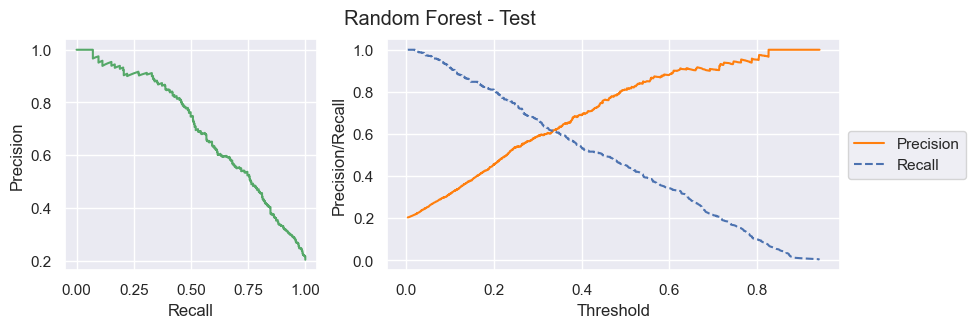

In [31]:
print('Train:')
print_scores(score_train_rfc)
pr_curve_plot(y_train, proba_train_rfc, title="Random Forest - Train")
print('Test:')
print_scores(score_test_rfc)
pr_curve_plot(y_test, proba_test_rfc, title="Random Forest - Test")

Precision: 0.8092
Recall: 0.7859


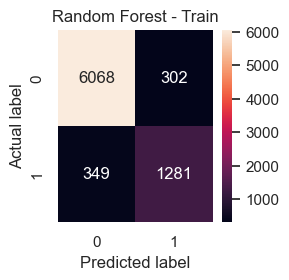

In [32]:
plot_cm(y_train, proba_train_rfc, t=0.35, title="Random Forest - Train")

Test
Precision: 0.6338
Recall: 0.5995


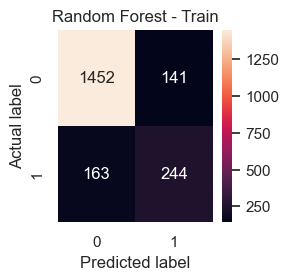

In [33]:
print("Test")
plot_cm(y_test, proba_test_rfc, t=0.35, title="Random Forest - Train")

The model performs really well on the training set, but doesn't generalize well to unseen data, a clear signal of overfitting. Probably the comparison model with some features removed will have a better performance.

Let's look at the feature importances for this model:

In [34]:
print_feature_importances(rs_cv_rfc)

cat__Geography_France 0.013
cat__Geography_Germany 0.037
cat__Geography_Spain 0.009
cat__Gender_Female 0.011
cat__Gender_Male 0.011
num_scaler__CreditScore 0.092
num_scaler__Age 0.304
num_scaler__Tenure 0.052
num_scaler__Balance 0.12
num_scaler__NumOfProducts 0.19
num_scaler__HasCrCard 0.011
num_scaler__IsActiveMember 0.056
num_scaler__EstimatedSalary 0.092


Age is the most important feature, followed by NumofProducts and Balance. During EDA, we saw that Age and NumofProducts had very different distributions for churn and non churning customers, thus it is expected that the model pays consider them as the most important features. The Balance feature had similar distributions for both type of customers, but the model consider this information as the third most important. 

### XGBoost Classifier

In [35]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=15)

pipe_xgb = make_pipeline(xgb, X_train)

param_grid = {
    "model__max_depth": [3, 4, 5, 7],
    "model__learning_rate": [0.1, 0.01, 0.05],
    "model__gamma": [0, 0.25, 1],
    "model__reg_lambda": [0, 1, 10],
    "model__scale_pos_weight": [1, 3, 5],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.5],
}

rs_cv_xgb = RandomizedSearchCV(estimator = pipe_xgb,
                               param_distributions = param_grid,
                               n_iter=30, 
                               cv=5,
                               verbose=0, 
                               scoring='average_precision',
                               random_state=81, 
                               n_jobs = 4)

rs_cv_xgb.fit(X_train, y_train)

proba_train_xgb = rs_cv_xgb.predict_proba(X_train)[:,1]
proba_test_xgb = rs_cv_xgb.predict_proba(X_test)[:,1]

score_train_xgb = score_model(rs_cv_xgb, X_train, y_train)
score_test_xgb = score_model(rs_cv_xgb, X_test, y_test)

# Saving scores
final_scores = save_scores(model_name="XGBoost",
                           score_train=score_train_xgb,
                           score_test=score_test_xgb,
                           df=final_scores
                           )

# Best parameters
rs_cv_xgb.best_params_

{'model__subsample': 0.8,
 'model__scale_pos_weight': 3,
 'model__reg_lambda': 1,
 'model__max_depth': 4,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.5}

Train:
precision_recall_auc 0.7742
accuracy 0.8546


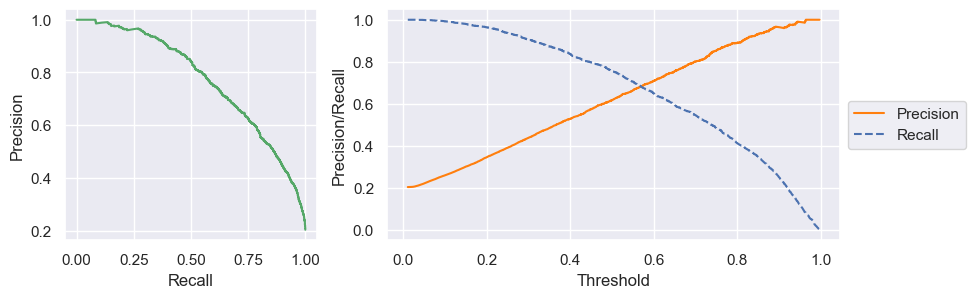

Test:
precision_recall_auc 0.7167
accuracy 0.8255


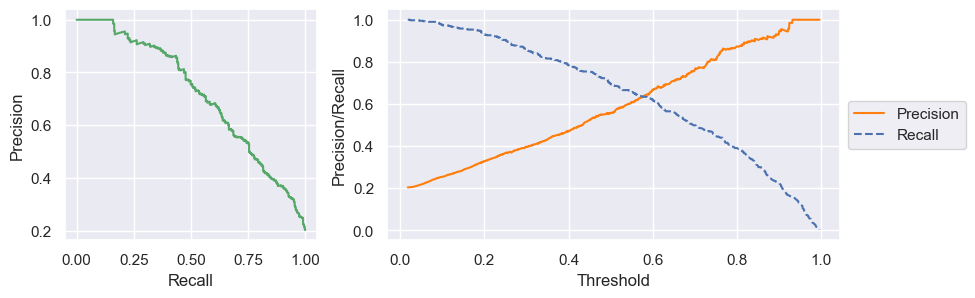

In [36]:
#Score
print('Train:')
print_scores(score_train_xgb)
pr_curve_plot(y_train, proba_train_xgb)
print('Test:')
print_scores(score_test_xgb)
pr_curve_plot(y_test, proba_test_xgb)

Precision: 0.7084
Recall: 0.6485


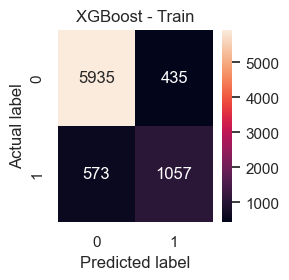

In [37]:
plot_cm(y_train, proba_train_xgb, t=0.6, title="XGBoost - Train")

Test: 
Precision: 0.6667
Recall: 0.6192


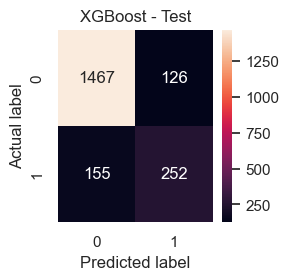

In [38]:
print("Test: ")
plot_cm(y_test, proba_test_xgb, t=0.6, title="XGBoost - Test")

The XGBoost is not overfitting, but has a lower performance in the test dataset compared to the Random Forest model. 

Let's look at the feature importances:

In [39]:
print_feature_importances(rs_cv_xgb)

cat__Geography_France 0.036
cat__Geography_Germany 0.092
cat__Geography_Spain 0.038
cat__Gender_Female 0.039
cat__Gender_Male 0.035
num_scaler__CreditScore 0.026
num_scaler__Age 0.162
num_scaler__Tenure 0.023
num_scaler__Balance 0.054
num_scaler__NumOfProducts 0.265
num_scaler__HasCrCard 0.018
num_scaler__IsActiveMember 0.186
num_scaler__EstimatedSalary 0.026


The most important feature for the XGBoost model is the NumOfProducts, followed by IsActiveMember and Age. Thus, it pays attention to different aspects of the data to make its predictions, compared to the Random Forest model. The Balance feature, that is very important for the Random Forest, does not have a high importance for XGBoost. 

In [40]:
final_scores

,Model,Dataset,PR AUC,Accuracy
0,Logistic Regression,Train,0.467083,0.810750
1,Logistic Regression,Test,0.477787,0.808000
0,Random Forest,Train,0.900662,0.904375
1,Random Forest,Test,0.699235,0.866500
0,XGBoost,Train,0.774226,0.854625
1,XGBoost,Test,0.716734,0.825500


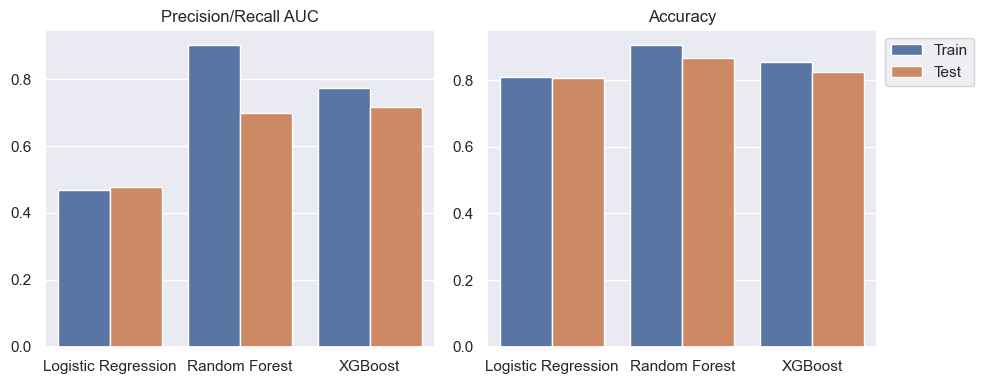

In [41]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
sns.barplot(x='Model', y='PR AUC', data=final_scores, hue='Dataset')
ax1.set_title('Precision/Recall AUC')
ax1.set(xlabel=None, ylabel=None)
ax1.legend_.remove()

ax2 = fig.add_subplot(122)
sns.barplot(x='Model', y='Accuracy', data=final_scores, hue='Dataset')
ax2.set_title('Accuracy')
ax2.set(xlabel=None, ylabel=None)
ax2.legend(bbox_to_anchor=(1, 1))

plt.close(2)
plt.close(3)
plt.tight_layout()

The PR AUC of the XGBoost is better, and it overfits less than the Random Forest model. The accuracy of Random Forest is best, though.

## Comparison Model
Now, let's train a comparison model where we remove those features with similar distributions for churning and non-churning customers: Estimated Salary, Balance and HasCrCard.

In [42]:
# Removing target from train dataset
drop_cols = [
    'Exited',
    'EstimatedSalary',
    'Balance',
    'HasCrCard'
]

X_train_mod = train_df.drop(drop_cols, axis=1)
X_test_mod = test_df.drop(drop_cols, axis=1)

X_cat_cols = list(X_train_mod.loc[:, X_train.dtypes == object].columns)
X_num_cols = list(X_train_mod.loc[:, X_train.dtypes != object].columns)

In [43]:
final_scores_mod = pd.DataFrame({"Model": [], 
                                 "Dataset": [], 
                                 "PR AUC": [],
                                 "Accuracy": []})

### Logistic Regression

In [83]:
logreg = LogisticRegression(random_state=10)

pipe_logreg_mod = make_pipeline(logreg, X_train_mod)

param_grid_lr = {
                 'model__C': [0.001, 0.01, 0.1, 0.5, 1, 10],
                 'model__solver': ['lbfgs', 'liblinear'],
                 'model__penalty': ['l2'],
                 'model__max_iter': [100, 200, 300, 400],
                }

gs_cv_lr_mod = GridSearchCV(pipe_logreg_mod, 
                            param_grid_lr,
                            scoring='average_precision', 
                            cv=5)

gs_cv_lr_mod.fit(X_train_mod, y_train)

proba_train_lr_mod = gs_cv_lr_mod.predict_proba(X_train_mod)[:,1]
proba_test_lr_mod = gs_cv_lr_mod.predict_proba(X_test_mod)[:,1]

score_train_lr_mod = score_model(gs_cv_lr_mod, X_train_mod, y_train)
score_test_lr_mod = score_model(gs_cv_lr_mod, X_test_mod, y_test)

# Saving scores
final_scores_mod = save_scores(model_name="Logistic Regression",
                               score_train=score_train_lr_mod,
                               score_test=score_test_lr_mod,
                               df=final_scores_mod
                              )

Train:
precision_recall_auc 0.4649
accuracy 0.8122


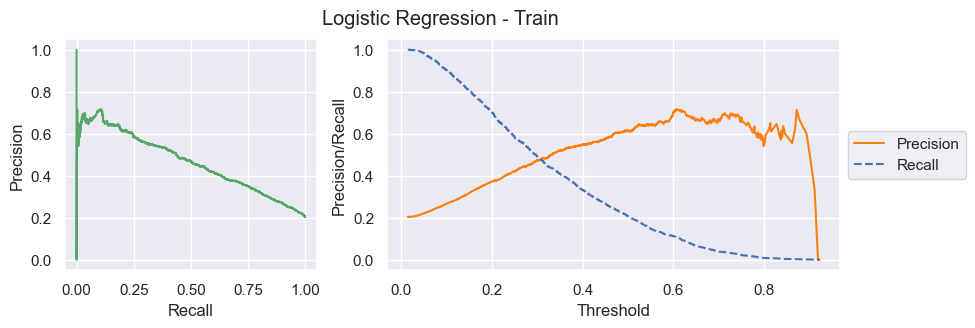

Test:
precision_recall_auc 0.4649
accuracy 0.8122


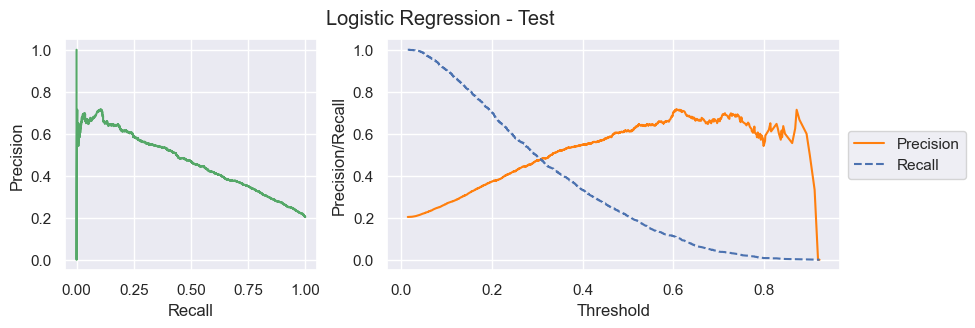

In [73]:
#Score
print('Train:')
print_scores(score_train_lr_mod)
pr_curve_plot(y_train, proba_train_lr_mod, title="Logistic Regression - Train")
print('Test:')
print_scores(score_train_lr_mod)
pr_curve_plot(y_train, proba_train_lr_mod, title="Logistic Regression - Test")

Precision: 0.4732
Recall: 0.492


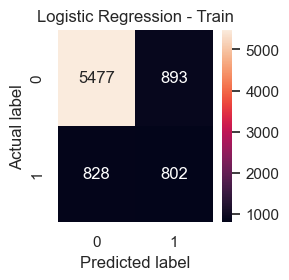

In [81]:
plot_cm(y_train, proba_train_lr_mod, t=0.3, title="Logistic Regression - Train")

Precision: 0.5
Recall: 0.5135


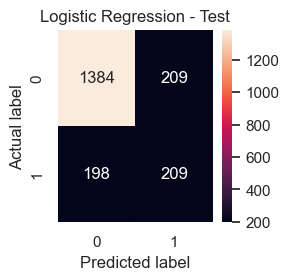

In [84]:
plot_cm(y_test, proba_test_lr_mod, t=0.3, title="Logistic Regression - Test")

### Random Forest

In [47]:
rfc = RandomForestClassifier(random_state=15)

pipe_rfc_cv_mod = make_pipeline(rfc, X_train_mod)

param_grid_rfc = {
    'model__max_depth': [10, 20, 50, 100, 200, None],
    'model__n_estimators': [10, 20, 50, 100, 300, 500],
    'model__max_leaf_nodes': [4, 8, 16, 24, None],
    'model__min_samples_leaf': [1, 5, 10, 20],
}

rs_cv_rfc_mod = RandomizedSearchCV(estimator = pipe_rfc_cv_mod,
                                   param_distributions = param_grid_rfc,
                                   n_iter=30, cv=5,
                                   verbose=0, scoring='average_precision',
                                   random_state=81, n_jobs = 4)

rs_cv_rfc_mod.fit(X_train_mod, y_train)

# Predictions
proba_train_rfc_mod = rs_cv_rfc_mod.predict_proba(X_train_mod)[:,1] 
proba_test_rfc_mod = rs_cv_rfc_mod.predict_proba(X_test_mod)[:,1] 

# Scores
score_train_rfc_mod = score_model(rs_cv_rfc_mod, X_train_mod, y_train)
score_test_rfc_mod = score_model(rs_cv_rfc_mod, X_test_mod, y_test)

# Saving scores
final_scores_mod = save_scores(model_name="Random Forest",
                               score_train=score_train_rfc_mod,
                               score_test=score_test_rfc_mod,
                               df=final_scores_mod
                              )


# Best Params
rs_cv_rfc_mod.best_params_

{'model__n_estimators': 500,
 'model__min_samples_leaf': 1,
 'model__max_leaf_nodes': 24,
 'model__max_depth': 200}

In [48]:
print_feature_importances(rs_cv_rfc_mod)

cat__Geography_France 0.012
cat__Geography_Germany 0.076
cat__Geography_Spain 0.007
cat__Gender_Female 0.013
cat__Gender_Male 0.011
num_scaler__CreditScore 0.029
num_scaler__Age 0.428
num_scaler__Tenure 0.008
num_scaler__NumOfProducts 0.317
num_scaler__IsActiveMember 0.101


Train:
precision_recall_auc 0.6974
accuracy 0.8611


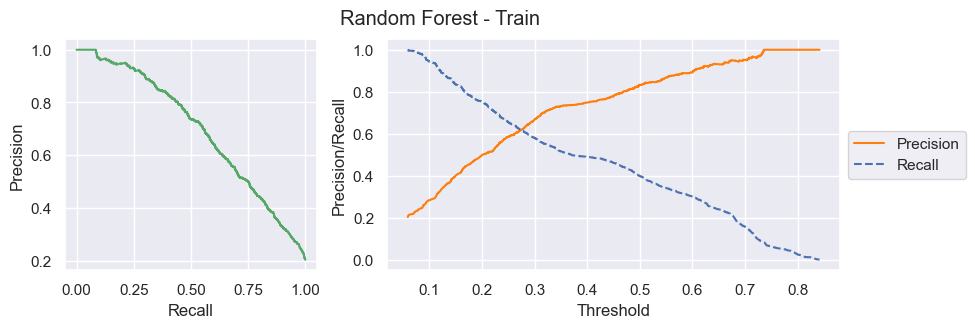

Test:
precision_recall_auc 0.6992
accuracy 0.8665


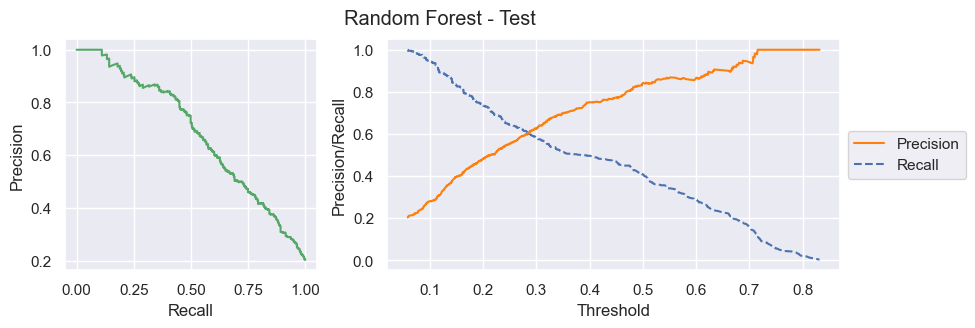

In [74]:
print('Train:')
print_scores(score_train_rfc_mod)
pr_curve_plot(y_train, proba_train_rfc_mod, title="Random Forest - Train")

print('Test:')
print_scores(score_test_rfc)
pr_curve_plot(y_test, proba_test_rfc_mod, title="Random Forest - Test")

Precision: 0.669
Recall: 0.5804


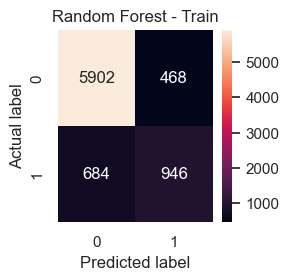

In [75]:
plot_cm(y_train, proba_train_rfc_mod, t=0.3, title="Random Forest - Train")

Precision: 0.6233
Recall: 0.5774


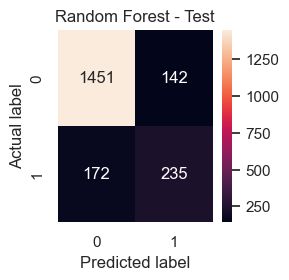

In [76]:
plot_cm(y_test, proba_test_rfc_mod, t=0.3, title="Random Forest - Test")

In [52]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=15)

pipe_xgb_mod = make_pipeline(xgb, X_train_mod)

param_grid = {
    "model__max_depth": [3, 4, 5, 7],
    "model__learning_rate": [0.1, 0.01, 0.05],
    "model__gamma": [0, 0.25, 1],
    "model__reg_lambda": [0, 1, 10],
    "model__scale_pos_weight": [1, 3, 5],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.5],
}

rs_cv_xgb_mod = RandomizedSearchCV(estimator = pipe_xgb_mod,
                                   param_distributions = param_grid,
                                   n_iter=30, 
                                   cv=5,
                                   verbose=0, 
                                   scoring='average_precision',
                                   random_state=81, 
                                   n_jobs = 4)

rs_cv_xgb_mod.fit(X_train_mod, y_train)

proba_train_xgb_mod = rs_cv_xgb_mod.predict_proba(X_train_mod)[:,1]
proba_test_xgb_mod = rs_cv_xgb_mod.predict_proba(X_test_mod)[:,1]

score_train_xgb_mod = score_model(rs_cv_xgb_mod, X_train_mod, y_train)
score_test_xgb_mod = score_model(rs_cv_xgb_mod, X_test_mod, y_test)

# Saving scores
final_scores_mod = save_scores(model_name="XGBoost",
                               score_train=score_train_xgb_mod,
                               score_test=score_test_xgb_mod,
                               df=final_scores_mod)

rs_cv_xgb_mod.best_params_

{'model__subsample': 0.8,
 'model__scale_pos_weight': 1,
 'model__reg_lambda': 0,
 'model__max_depth': 3,
 'model__learning_rate': 0.1,
 'model__gamma': 1,
 'model__colsample_bytree': 0.5}

Train:
precision_recall_auc 0.7108
accuracy 0.8646


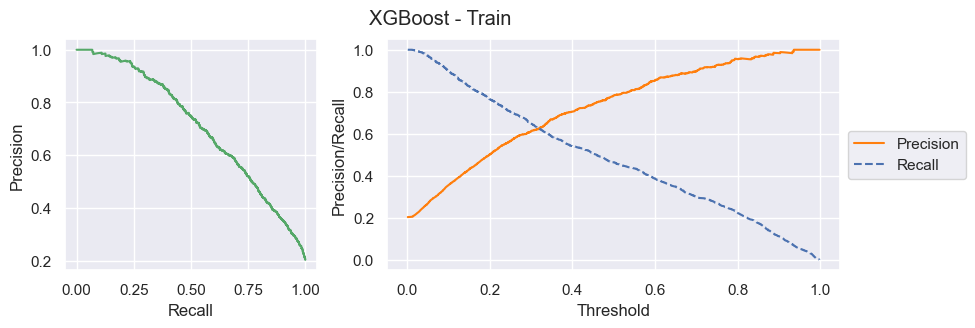

Test:
precision_recall_auc 0.699
accuracy 0.8665


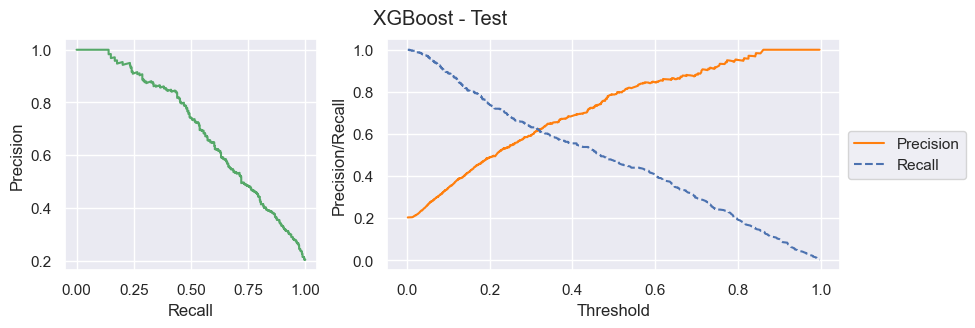

In [80]:
print('Train:')
print_scores(score_train_xgb_mod)
pr_curve_plot(y_train, proba_train_xgb_mod, title="XGBoost - Train")

print('Test:')
print_scores(score_test_xgb_mod)
pr_curve_plot(y_test, proba_test_xgb_mod, title="XGBoost - Test")

Precision: 0.6105
Recall: 0.6472


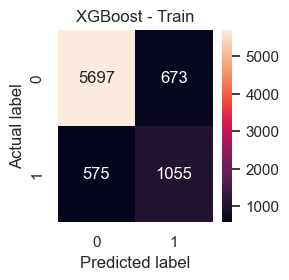

In [78]:
plot_cm(y_train, proba_train_xgb_mod, t=0.3, title="XGBoost - Train")

Precision: 0.5922
Recall: 0.6314


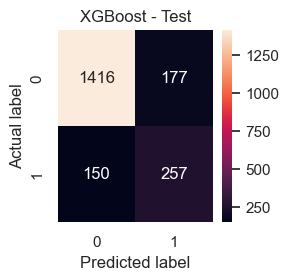

In [77]:
plot_cm(y_test, proba_test_xgb_mod, t=0.3, title="XGBoost - Test")

In [56]:
final_scores_mod

,Model,Dataset,PR AUC,Accuracy
0,Logistic Regression,Train,0.464869,0.812250
1,Logistic Regression,Test,0.480356,0.809500
0,Random Forest,Train,0.697357,0.861125
1,Random Forest,Test,0.681719,0.864000
0,XGBoost,Train,0.710785,0.864625
1,XGBoost,Test,0.699003,0.866500


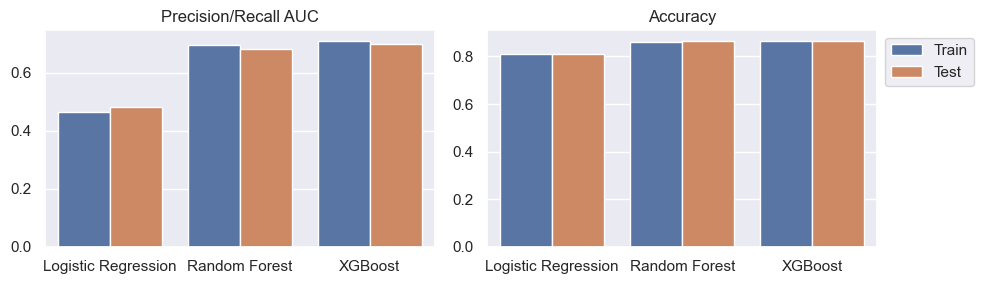

In [57]:
fig = plt.figure(figsize=(10,3))

ax1 = fig.add_subplot(121)
sns.barplot(x='Model', y='PR AUC', data=final_scores_mod, hue='Dataset')
ax1.set_title('Precision/Recall AUC')
ax1.set(xlabel=None, ylabel=None)
ax1.legend_.remove()

ax2 = fig.add_subplot(122)
sns.barplot(x='Model', y='Accuracy', data=final_scores_mod, hue='Dataset')
ax2.set_title('Accuracy')
ax2.set(xlabel=None, ylabel=None)
ax2.legend(bbox_to_anchor=(1,1))

plt.close(2)
plt.close(3)
plt.tight_layout()

## Conclusion
Finally, let's compare the baseline and comparison models:

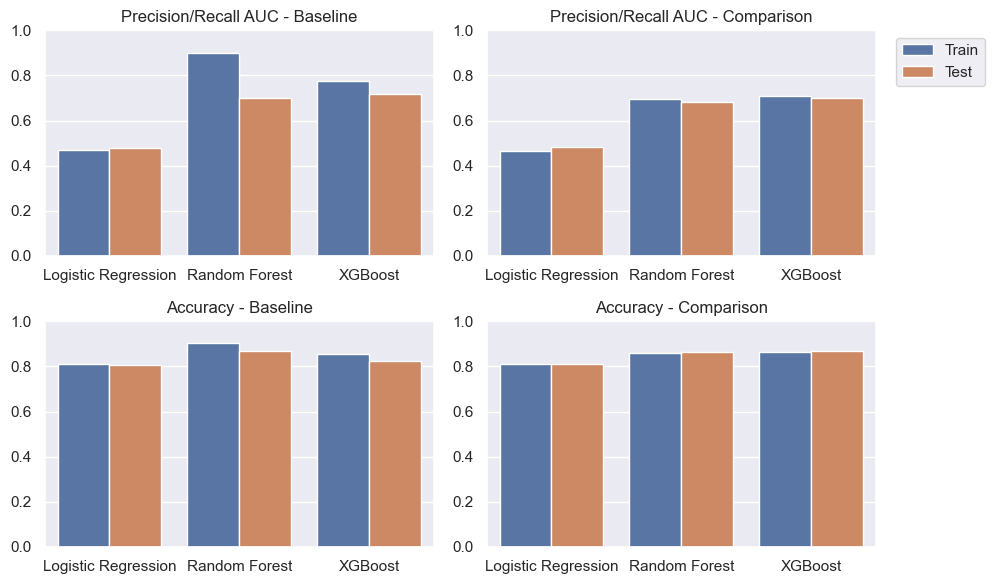

In [58]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(221)
sns.barplot(x='Model', y='PR AUC', data=final_scores, hue='Dataset')
ax1.set_title('Precision/Recall AUC - Baseline')
ax1.set(xlabel=None, ylabel=None)
ax1.legend_.remove()
ax1.set_ylim([0,1])

ax2 = fig.add_subplot(223)
sns.barplot(x='Model', y='Accuracy', data=final_scores, hue='Dataset')
ax2.set_title('Accuracy - Baseline')
ax2.set(xlabel=None, ylabel=None)
ax2.legend_.remove()
ax2.set_ylim([0,1])


ax3 = fig.add_subplot(222)
sns.barplot(x='Model', y='PR AUC', data=final_scores_mod, hue='Dataset')
ax3.set_title('Precision/Recall AUC - Comparison')
ax3.set(xlabel=None, ylabel=None)
ax3.legend(bbox_to_anchor=(1.3,1))
ax3.set_ylim([0,1])

ax4 = fig.add_subplot(224)
sns.barplot(x='Model', y='Accuracy', data=final_scores_mod, hue='Dataset')
ax4.set_title('Accuracy - Comparison')
ax4.set(xlabel=None, ylabel=None)
ax4.legend_.remove()
ax4.set_ylim([0,1])

plt.close(2)
plt.close(3)
plt.tight_layout()

We can see that, for the 3 models, the perfomances on test sets are very similar for both baseline and comparison approaches. However, the baseline approach is overfitting, mainly in the Random Forest model. The comparison model does overfits are all, and generalizing well to unseen data. 

In [67]:
final_scores

,Model,Dataset,PR AUC,Accuracy
0,Logistic Regression,Train,0.467083,0.810750
1,Logistic Regression,Test,0.477787,0.808000
0,Random Forest,Train,0.900662,0.904375
1,Random Forest,Test,0.699235,0.866500
0,XGBoost,Train,0.774226,0.854625
1,XGBoost,Test,0.716734,0.825500


In [68]:
final_scores_mod

,Model,Dataset,PR AUC,Accuracy
0,Logistic Regression,Train,0.464869,0.812250
1,Logistic Regression,Test,0.480356,0.809500
0,Random Forest,Train,0.697357,0.861125
1,Random Forest,Test,0.681719,0.864000
0,XGBoost,Train,0.710785,0.864625
1,XGBoost,Test,0.699003,0.866500


Based on these criteria, the comparison approach, with the XGBoost model will be chosen. It showed a better overall performance, no overfitting, and precision/recall metrics above 60%. Thus, it is possible to conclude that this is the best model.